# **Model testing and Inference**


Defining root folder for root resources access such as `data/` and `utils/`


In [4]:
from pathlib import Path
import sys

ROOT_DIR = Path.cwd().parent
sys.path.insert(0, str(ROOT_DIR))

## Importing libraries


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from pathlib import Path
from torch import nn
from utils import helpers
import os
from PIL import Image

/home/shiba/Desktop/nail-disease-classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data


In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader


# Normalization and transforming data into tensors
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

DATA_DIR = ROOT_DIR / "data"
TEST_DIR = DATA_DIR / "test"
test_data = ImageFolder(root=TEST_DIR,
                        transform=transform,
                        target_transform=None)

class_names = test_data.classes
num_classes = len(class_names)

# Test Dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Models


In [7]:
OUTPUTS_PATH = ROOT_DIR / "outputs"
model_dict = {}

### EfficientNetV2S


In [8]:
from torchvision import models

MODEL_NAME = "efficientnetv2s"
EPOCH = 5

# Rebuilding model
efficientnetv2s = models.efficientnet_v2_s()
efficientnetv2s.classifier[1] = nn.Linear(
    efficientnetv2s.classifier[1].in_features, num_classes)
efficientnetv2s = efficientnetv2s.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
efficientnetv2s.load_state_dict(state_dict=state_dict)

# Appending to model dict
model_dict[MODEL_NAME] = efficientnetv2s

### SwinV2B


In [9]:
MODEL_NAME = "swinv2b"
EPOCH = 5

# Rebuilding Model
swinv2b = models.swin_v2_b()
swinv2b.head = nn.Linear(in_features=1024, out_features=num_classes, bias=True)
swinv2b.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
swinv2b.load_state_dict(state_dict=state_dict)

model_dict[MODEL_NAME] = swinv2b

### RegNetY16GF


In [10]:
MODEL_NAME = "regnety16gf"
EPOCH = 5

# Rebuilding Model
regnety16gf = models.regnet_y_16gf()
regnety16gf.fc = nn.Linear(
    in_features=3024, out_features=num_classes, bias=True)
regnety16gf.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
regnety16gf.load_state_dict(state_dict=state_dict)

model_dict[MODEL_NAME] = regnety16gf

### Resnet50


In [11]:
MODEL_NAME = "resnet50"
EPOCH = 5

# Rebuilding Model
resnet50 = models.resnet50()
resnet50.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
resnet50.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
resnet50.load_state_dict(state_dict=state_dict)

model_dict[MODEL_NAME] = resnet50

### VGG16


In [12]:
MODEL_NAME = "vgg16"
EPOCH = 5

# Rebuilding Model
vgg16 = models.vgg16()
# Change VGG16 to output 10 classes
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
vgg16 = vgg16.to(device)

# Loading weights
WEIGHTS_PATH = OUTPUTS_PATH / MODEL_NAME / \
    "weights" / f"{MODEL_NAME}_epoch{EPOCH}.pth"
state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
vgg16.load_state_dict(state_dict=state_dict)

model_dict[MODEL_NAME] = vgg16

## Making single predictions


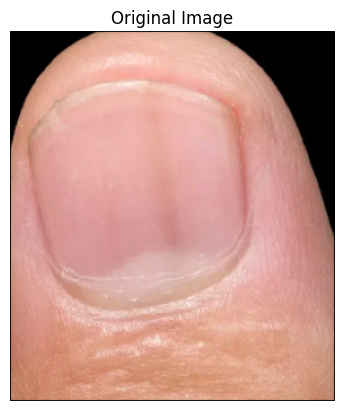

Grad-CAM failed: 'Sequential' object has no attribute 'SwinTransformerBlockV2'


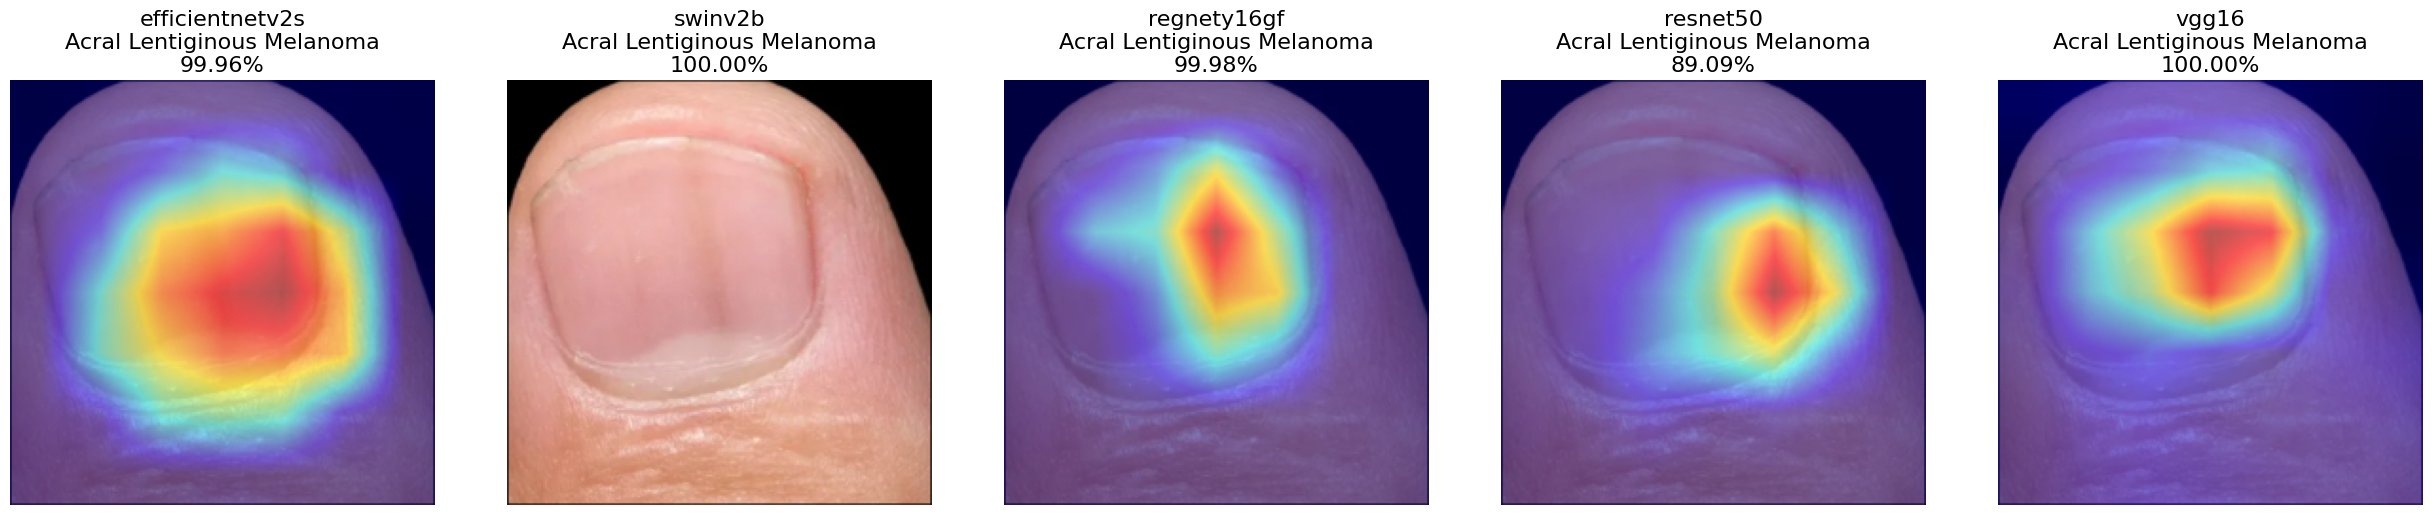

In [46]:
FILE_NAME = DATA_DIR / "4.png"

IMAGE_PATH = ROOT_DIR / FILE_NAME

img = torchvision.io.decode_image(IMAGE_PATH)
plt.title("Original Image")
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
plt.show()

fig, axs = plt.subplots(1, len(model_dict), figsize=(5 * len(model_dict), 5))

for i, (name, model) in enumerate(model_dict.items()):
    pred_prob, pred_class, cam_img = helpers.make_single_prediction(
        model=model,
        model_name=name,
        image_path=IMAGE_PATH,
        class_names=class_names,
        transforms=transform,
        device=device,
        show_confidence=False
    )

    axs[i].imshow(cam_img)
    axs[i].axis("off")
    axs[i].set_title(
        f"{name}\n{class_names[pred_class]}\n{pred_prob.max()*100:.2f}%", fontsize=16)

plt.tight_layout()
plt.show()

## Systemic Disease Associations


### **Melanonychia and Melanoma**

**Melanonychia**

- Nearly all Afro-Caribbean people will develop black-brown pigmentation of the nails by the age of 50.
- Melanonychia affects up to 20% of Japanese people.
- White-skinned people are less commonly affected.

Causes of Melanonychia

| Cause                      | Example                                                                                                                                                 |
| :------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Physiological (functional) | Racial Variation <br>Prenancy                                                                                                                           |
| Trauma                     | Nail biting, chewing, breaking and picking <br>Friction due to deformity or footwear                                                                    |
| Inflamattory skin disease  | Psoriasis <br>Acrodermatitis of Hallopeau <br>Lichen planus <br>Amyloidosis                                                                             |
| Nonmelanoctyc lesions      | Intraepidermal carcinoma <br>Basal cell carcinoma <br>viral wart                                                                                        |
| Nutritional deficiency     | Vitamin B12 or folate deficiency                                                                                                                        |
| Endocrine Disorders        | Addison disease <br>Cushing syndrome <br>Hyperthyroidism <br>Acromegaly                                                                                 |
| Another systemic disease   | Haemosiderosis <br>Porphy cutanea tarda <br> Human immunodeficiency virus infection (HIV) <br>Sytemic lupus erythematosus <br>Systemic sclerosis        |
| Syndromes                  | Laugier-Hunziker syndrome <br> Peutz-Jeghers syndrome <br>Touraine syndrome                                                                             |
| Iatrogenic                 | Phototherapy <br>X-ray exposure; eletron beam therapy                                                                                                   |
| Medications                | Chemotherapy agents (especially hydroxyurea, busulfan, bleomycin, adriamycin, doxorubicin, cyclophosphamide, 5-fluorouracil) <br> Anti-malarial therapy |

**Acral Lentiginous Melanoma**: https://dermnetnz.org/topics/melanoma-of-the-nail-unit

- Acral Lentiginous Melanoma: 2 - 3% of melanoma diagnoses
- ALM in dark skinned populations: 40 - 60% of melanoma diagnoses

**Melanoma of the nail unit**: https://dermnetnz.org/topics/melanoma-of-the-nail-unit

- Injury or trauma may be a factor, accounting for the greater incidence in the big toe and thumb (75–90% of cases).
- Malignant melanomas in white skinned population: 0.7 - 3.5%
- Malignant melanomas in dark skinned and asian population: up to 75%
- Melanoma of the nail unit is hypomelanotic or amelanotic in up to 50% of all cases.
- Longitudinal melanonychia in white skinned individuals: 1%
- Longitudinal melanonychia in dark-skinned races: estimated 100% of African-Americans by the age of 50 and around 20% of Asians

### **Beau's Lines**


### From Grok

| Nail Feature               | Rank | Systemic Disease                     | Probability/Association         | Details                                                                                     |
| -------------------------- | ---- | ------------------------------------ | ------------------------------- | ------------------------------------------------------------------------------------------- |
| **Melanonychia**           | 1    | Endocrine disorders                  | Frequent                        | Includes Addison's disease, Cushing's syndrome, hyperthyroidism; diffuse or multiple bands. |
|                            | 2    | HIV/AIDS                             | Common                          | Longitudinal/transverse bands in immunocompromised patients.                                |
|                            | 3    | Nutritional deficiencies             | Less common                     | Protein, vitamin D, B12 deficiencies linked to malnutrition.                                |
|                            | 4    | Connective tissue diseases           | Rare                            | SLE, systemic sclerosis; seen in inflammatory nail changes.                                 |
|                            | 5    | Other (e.g., alkaptonuria)           | Very rare                       | Includes hemosiderosis, porphyria; affects multiple nails.                                  |
| **Beau's Lines**           | 1    | Severe infections/systemic illnesses | Most common                     | Pneumonia, mumps, severe COVID-19; disrupts nail matrix growth.                             |
|                            | 2    | Chemotherapy                         | Common                          | Targets nail matrix, causing grooves.                                                       |
|                            | 3    | Nutritional deficiencies             | Less common                     | Iron, zinc, protein deficiencies weaken nail matrix.                                        |
|                            | 4    | Autoimmune diseases                  | Less common                     | SLE, rheumatoid arthritis, psoriasis; linked to inflammation.                               |
|                            | 5    | Endocrine disorders                  | Rare                            | Hypoparathyroidism, hypothyroidism; affects nail growth.                                    |
|                            | 6    | Peripheral vascular disease          | Rare                            | Reduced blood flow disrupts nail matrix.                                                    |
|                            | 7    | Diabetes                             | Very rare                       | Chronic diabetes may cause nail changes.                                                    |
| **Blue Finger (Cyanosis)** | 1    | Congenital heart diseases            | Most common                     | Central cyanosis in cyanotic congenital heart diseases.                                     |
|                            | 2    | Congestive cardiac failure           | Common                          | Peripheral cyanosis due to reduced oxygen delivery.                                         |
|                            | 3    | Peripheral vascular disease          | Less common                     | Reduced blood flow causes peripheral cyanosis.                                              |
|                            | 4    | Shock                                | Rare                            | Inadequate oxygen delivery in severe shock.                                                 |
| **Clubbing**               | 1    | Pulmonary diseases                   | Most common                     | Lung cancer, bronchiectasis, cystic fibrosis; due to chronic hypoxia.                       |
|                            | 2    | Cardiovascular diseases              | Common                          | Cyanotic congenital heart diseases, endocarditis.                                           |
|                            | 3    | Gastrointestinal diseases            | Less common                     | IBD, hepatic cirrhosis; less frequent.                                                      |
|                            | 4    | Other (e.g., thyroid disease)        | Rare                            | Thyroid disease, mesothelioma; rare associations.                                           |
| **Koilonychia**            | 1    | Iron deficiency anemia               | ~50% in Plummer-Vinson syndrome | Common in Plummer-Vinson syndrome; improves with iron supplementation.                      |
|                            | 2    | Malnutrition                         | Common                          | Severe malnutrition leads to spoon nails.                                                   |
|                            | 3    | Hemochromatosis                      | Less common                     | Iron overload, rare association.                                                            |
|                            | 4    | Thyroid disorders                    | Rare                            | Hypothyroidism, less frequent.                                                              |
|                            | 5    | Upper GI malignancy                  | Very rare                       | Esophageal/gastric cancer, rare association.                                                |
| **Muehrcke's Lines**       | 1    | Nephrotic syndrome                   | Common (albumin <2 g/dL)        | Linked to hypoalbuminemia in kidney disease.                                                |
|                            | 2    | Liver disease                        | Common                          | Cirrhosis causes hypoalbuminemia, leading to white bands.                                   |
|                            | 3    | Malnutrition                         | Less common                     | Severe protein deficiency, less frequent.                                                   |
|                            | 4    | Chemotherapy                         | Rare                            | Certain drugs cause nail changes.                                                           |
| **Onychogryphosis**        | 1    | Diabetes                             | Common                          | Common in diabetic foot complications, nail dystrophy.                                      |
|                            | 2    | Peripheral vascular disease          | Common                          | Reduced blood flow causes nail thickening.                                                  |
|                            | 3    | Psoriasis                            | Less common                     | Inflammatory skin condition, rare cause.                                                    |
|                            | 4    | Ichthyosis                           | Rare                            | Genetic skin disorders, infrequent.                                                         |
|                            | 5    | Other (e.g., syphilis)               | Very rare                       | Hyperuricemia, CNS diseases, syphilis, leishmaniasis; very rare.                            |
| **Pitting**                | 1    | Psoriasis                            | Most common                     | Characteristic pitting, often with psoriatic arthritis.                                     |
|                            | 2    | Psoriatic arthritis                  | Common                          | Systemic form of psoriasis affecting joints and nails.                                      |
|                            | 3    | Systemic lupus erythematosus (SLE)   | Less common                     | Pitting as part of dermatological manifestations.                                           |
|                            | 4    | Dermatomyositis                      | Rare                            | Connective tissue disease, rare association.                                                |
|                            | 5    | Other (e.g., sarcoidosis)            | Very rare                       | Syphilis, sarcoidosis, pemphigus vulgaris; very infrequent.                                 |
| **Terry's Nails**          | 1    | Congestive cardiac failure           | Common                          | Common in heart failure, chronic illness.                                                   |
|                            | 2    | Diabetes mellitus                    | Common                          | Adult-onset diabetes, linked to vascular changes.                                           |
|                            | 3    | Peripheral vascular disease          | Common                          | Reduced blood flow, common in elderly.                                                      |
|                            | 4    | Liver disease                        | Less common                     | Cirrhosis, less frequent association.                                                       |
|                            | 5    | HIV                                  | Rare                            | Rare association with HIV infection.                                                        |


## Inference


In [40]:
nail_disease_inference = {
    "Acral Lentiginous Melanoma": [
        {"disease": "Endocrine disorders", "probability": "Frequent",
            "details": "Addison's disease, Cushing's syndrome, hyperthyroidism; diffuse or multiple bands"},
        {"disease": "HIV/AIDS", "probability": "Common",
            "details": "Longitudinal/transverse bands in immunocompromised patients"},
        {"disease": "Nutritional deficiencies", "probability": "Less common",
            "details": "Protein, vitamin D, B12 deficiencies linked to malnutrition"},
        {"disease": "Connective tissue diseases", "probability": "Rare",
            "details": "SLE, systemic sclerosis; seen in inflammatory nail changes"},
        {"disease": "Other (e.g., alkaptonuria)", "probability": "Very rare",
         "details": "Includes hemosiderosis, porphyria; affects multiple nails"}
    ],
    "Beaus Lines": [
        {"disease": "Severe infections/systemic illnesses", "probability": "Most common",
            "details": "Pneumonia, mumps, severe COVID-19; disrupts nail matrix growth"},
        {"disease": "Chemotherapy", "probability": "Common",
            "details": "Targets nail matrix, causing grooves"},
        {"disease": "Nutritional deficiencies", "probability": "Less common",
            "details": "Iron, zinc, protein deficiencies weaken nail matrix"},
        {"disease": "Autoimmune diseases", "probability": "Less common",
            "details": "SLE, rheumatoid arthritis, psoriasis; linked to inflammation"},
        {"disease": "Endocrine disorders", "probability": "Rare",
            "details": "Hypoparathyroidism, hypothyroidism; affects nail growth"},
        {"disease": "Peripheral vascular disease", "probability": "Rare",
            "details": "Reduced blood flow disrupts nail matrix"},
        {"disease": "Diabetes", "probability": "Very rare",
            "details": "Chronic diabetes may cause nail changes"}
    ],
    "Blue Finger": [
        {"disease": "Congenital heart diseases", "probability": "Most common",
            "details": "Central cyanosis in cyanotic congenital heart diseases"},
        {"disease": "Congestive cardiac failure", "probability": "Common",
            "details": "Peripheral cyanosis due to reduced oxygen delivery"},
        {"disease": "Peripheral vascular disease", "probability": "Less common",
            "details": "Reduced blood flow causes peripheral cyanosis"},
        {"disease": "Shock", "probability": "Rare",
            "details": "Inadequate oxygen delivery in severe shock"}
    ],
    "Clubbing": [
        {"disease": "Pulmonary diseases", "probability": "Most common",
            "details": "Lung cancer, bronchiectasis, cystic fibrosis; due to chronic hypoxia"},
        {"disease": "Cardiovascular diseases", "probability": "Common",
            "details": "Cyanotic congenital heart diseases, endocarditis"},
        {"disease": "Gastrointestinal diseases", "probability": "Less common",
            "details": "IBD, hepatic cirrhosis; less frequent"},
        {"disease": "Other (e.g., thyroid disease)", "probability": "Rare",
         "details": "Thyroid disease, mesothelioma; rare associations"}
    ],
    "Koilonychia": [
        {"disease": "Iron deficiency anemia", "probability": "~50% in Plummer-Vinson syndrome",
            "details": "Common in Plummer-Vinson syndrome; improves with iron supplementation"},
        {"disease": "Malnutrition", "probability": "Common",
            "details": "Severe malnutrition leads to spoon nails"},
        {"disease": "Hemochromatosis", "probability": "Less common",
            "details": "Iron overload, rare association"},
        {"disease": "Thyroid disorders", "probability": "Rare",
            "details": "Hypothyroidism, less frequent"},
        {"disease": "Upper GI malignancy", "probability": "Very rare",
            "details": "Esophageal/gastric cancer, rare association"}
    ],
    "Muehrckes Lines": [
        {"disease": "Nephrotic syndrome",
            "probability": "Common (albumin <2 g/dL)", "details": "Linked to hypoalbuminemia in kidney disease"},
        {"disease": "Liver disease", "probability": "Common",
            "details": "Cirrhosis causes hypoalbuminemia, leading to white bands"},
        {"disease": "Malnutrition", "probability": "Less common",
            "details": "Severe protein deficiency, less frequent"},
        {"disease": "Chemotherapy", "probability": "Rare",
            "details": "Certain drugs cause nail changes"}
    ],
    "Onychogryphosis": [
        {"disease": "Diabetes", "probability": "Common",
            "details": "Common in diabetic foot complications, nail dystrophy"},
        {"disease": "Peripheral vascular disease", "probability": "Common",
            "details": "Reduced blood flow causes nail thickening"},
        {"disease": "Psoriasis", "probability": "Less common",
            "details": "Inflammatory skin condition, rare cause"},
        {"disease": "Ichthyosis", "probability": "Rare",
            "details": "Genetic skin disorders, infrequent"},
        {"disease": "Other (e.g., syphilis)", "probability": "Very rare",
         "details": "Hyperuricemia, CNS diseases, syphilis, leishmaniasis; very rare"}
    ],
    "Pitting": [
        {"disease": "Psoriasis", "probability": "Most common",
            "details": "Characteristic pitting, often with psoriatic arthritis"},
        {"disease": "Psoriatic arthritis", "probability": "Common",
            "details": "Systemic form of psoriasis affecting joints and nails"},
        {"disease": "Systemic lupus erythematosus (SLE)", "probability": "Less common",
         "details": "Pitting as part of dermatological manifestations"},
        {"disease": "Dermatomyositis", "probability": "Rare",
            "details": "Connective tissue disease, rare association"},
        {"disease": "Other (e.g., sarcoidosis)", "probability": "Very rare",
         "details": "Syphilis, sarcoidosis, pemphigus vulgaris; very infrequent"}
    ],
    "Terry-s Nail": [
        {"disease": "Congestive cardiac failure", "probability": "Common",
            "details": "Common in heart failure, chronic illness"},
        {"disease": "Diabetes mellitus", "probability": "Common",
            "details": "Adult-onset diabetes, linked to vascular changes"},
        {"disease": "Peripheral vascular disease", "probability": "Common",
            "details": "Reduced blood flow, common in elderly"},
        {"disease": "Liver disease", "probability": "Less common",
            "details": "Cirrhosis, less frequent association"},
        {"disease": "HIV", "probability": "Rare",
            "details": "Rare association with HIV infection"}
    ]
}

In [48]:
pred_prob, pred_class, cam_img = helpers.make_single_prediction(model=efficientnetv2s,
                                                                image_path=IMAGE_PATH,
                                                                class_names=class_names,
                                                                model_name="efficientnetv2s",
                                                                transforms=transform,
                                                                device=device)

predicted_nail_feature = class_names[pred_class]

print(
    f"\nPredicted Nail Feature: {predicted_nail_feature} \nConfidence: {pred_prob.max() * 100:.2f}%")
if predicted_nail_feature in nail_disease_inference:
    print("\n🔎 Systemic disease associations:")
    for entry in nail_disease_inference[predicted_nail_feature]:
        print(
            f"- {entry['disease']} ({entry['probability']}): {entry['details']}")
else:
    print("No systemic disease mapping available for this feature.")


Predicted Nail Feature: Acral Lentiginous Melanoma 
Confidence: 99.96%

🔎 Systemic disease associations:
- Endocrine disorders (Frequent): Addison's disease, Cushing's syndrome, hyperthyroidism; diffuse or multiple bands
- HIV/AIDS (Common): Longitudinal/transverse bands in immunocompromised patients
- Nutritional deficiencies (Less common): Protein, vitamin D, B12 deficiencies linked to malnutrition
- Connective tissue diseases (Rare): SLE, systemic sclerosis; seen in inflammatory nail changes
- Other (e.g., alkaptonuria) (Very rare): Includes hemosiderosis, porphyria; affects multiple nails
